# This Notebook is for the purpose of Data Preprocessing

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce RTX 3080 Ti


In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

### Let's try to write a custom dataset and dataloader

In [3]:
# Define a custom dataset
class SyntheticEventDataset(Dataset):

    # Basic instantiation
    def __init__(self, csv_folder_path):
        self.csv_files = [os.path.join(csv_folder_path, f) for f in os.listdir(csv_folder_path) if f.endswith('.csv')]
        self.data = []
        
        # Load each CSV file and preprocess the data
        for file in self.csv_files:
            df = pd.read_csv(file)
            for _, row in df.iterrows():
                # Extract parameters
                chirp_mass = row['chirp_mass (sol)']
                distance = row['distance (Mpc)']
                inclination = row['inclination (rad)']
                peak_snr = row['peak_snr']
                
                # Parse JSON-encoded waveform data
                waveform = json.loads(row['waveform (normalized)'])
                
                # Append to dataset
                self.data.append((torch.tensor(waveform, dtype=torch.float32),
                                  torch.tensor(chirp_mass, dtype=torch.float32)))
    # Get length of datset    
    def __len__(self):
        return len(self.data)

    # Fetch an item from the dataset
    def __getitem__(self, idx):
        return self.data[idx]

### Declare the dataset

In [ ]:
# Initialize Dataset and DataLoader
dataset = SyntheticEventDataset(csv_folder_path='SyntheticData/')

### Investigate the size and shape of the dataset

In [5]:
print(f"Total events in dataset: {len(dataset)}")
print("Example event (waveform, parameters):", dataset[0])  # Access the first event

Total events in dataset: 100100
Example event (waveform, parameters): (tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([2.2469e+01, 3.5700e+03, 7.1005e-01, 5.5196e+00]))


In [6]:
waveform, parameters = dataset[0]
print("Waveform shape:", waveform.shape)  # Shape of time-series data
print("Parameters shape:", parameters.shape)  # Shape of parameter tensor

Waveform shape: torch.Size([27500])
Parameters shape: torch.Size([4])


### Calculate some parameter statistics just for the heck of it

In [7]:
# Stack all parameter tensors for batch statistics
all_parameters = torch.stack([params for _, params in dataset])

# Calculate basic statistics
means = torch.mean(all_parameters, dim=0)
medians = torch.median(all_parameters, dim=0).values
std_devs = torch.std(all_parameters, dim=0)

print("Means:", means)
print("Medians:", medians)
print("Standard Deviations:", std_devs)

Means: tensor([4.1629e+01, 2.2533e+03, 1.5650e+00, 2.1793e+01])
Medians: tensor([4.0241e+01, 2.2520e+03, 1.5607e+00, 1.4210e+01])
Standard Deviations: tensor([1.8736e+01, 1.0110e+03, 9.0934e-01, 2.2843e+01])


### Ensure all waveforms are uniform in length

In [8]:
waveform_lengths = [waveform.shape[0] for waveform, _ in dataset]
unique_lengths = set(waveform_lengths)
print("Unique waveform lengths:", unique_lengths)

Unique waveform lengths: {27500}


### Plot histograms for each parameter distribution

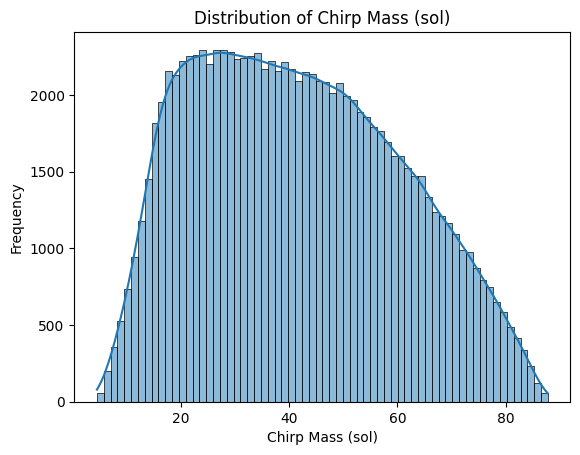

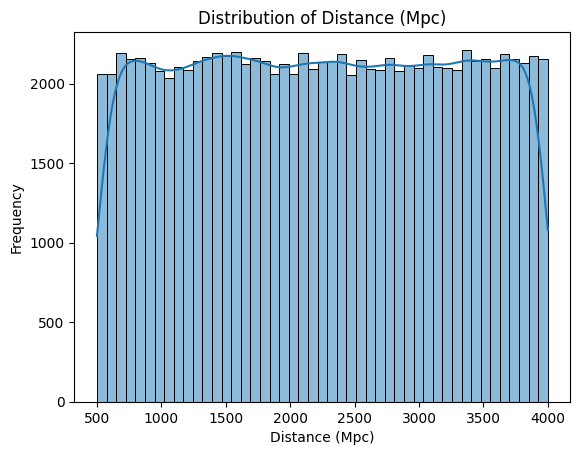

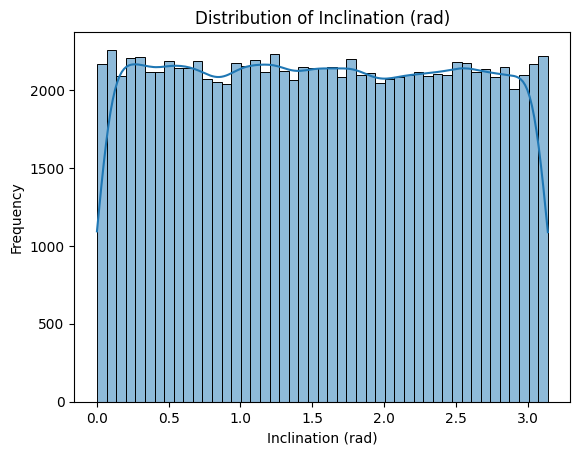

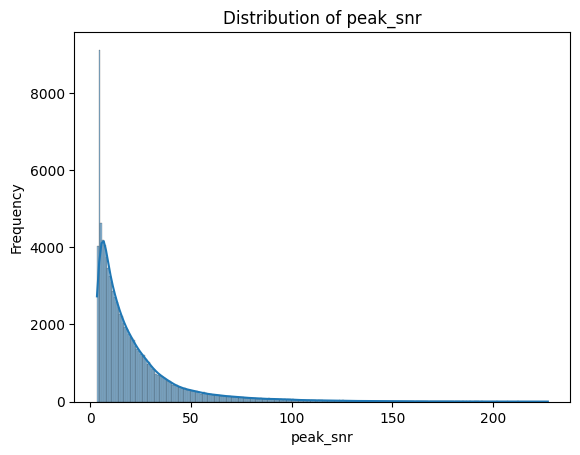

In [9]:
# Convert parameters to numpy for Seaborn
parameters_np = all_parameters.numpy()
parameter_names = ['Chirp Mass (sol)', 'Distance (Mpc)', 'Inclination (rad)', 'peak_snr']

# Plot histograms
for i, name in enumerate(parameter_names):
    sns.histplot(parameters_np[:, i], kde=True)
    plt.title(f"Distribution of {name}")
    plt.xlabel(name)
    plt.ylabel("Frequency")
    plt.show()

### Calculate a correlation matrix for the parameters

In [12]:
# Convert to DataFrame for easy correlation calculation
df_params = pd.DataFrame(parameters_np, columns=parameter_names)
correlation_matrix = df_params.corr()
print("Correlation matrix:")
correlation_matrix

Correlation matrix:


,Chirp Mass (sol),Distance (Mpc),Inclination (rad),peak_snr
Chirp Mass (sol),1.000000,-0.000150,0.000204,0.386047
Distance (Mpc),-0.000150,1.000000,-0.002885,-0.520037
Inclination (rad),0.000204,-0.002885,1.000000,-0.000992
peak_snr,0.386047,-0.520037,-0.000992,1.000000


### Let's plot a waveform from the dataset

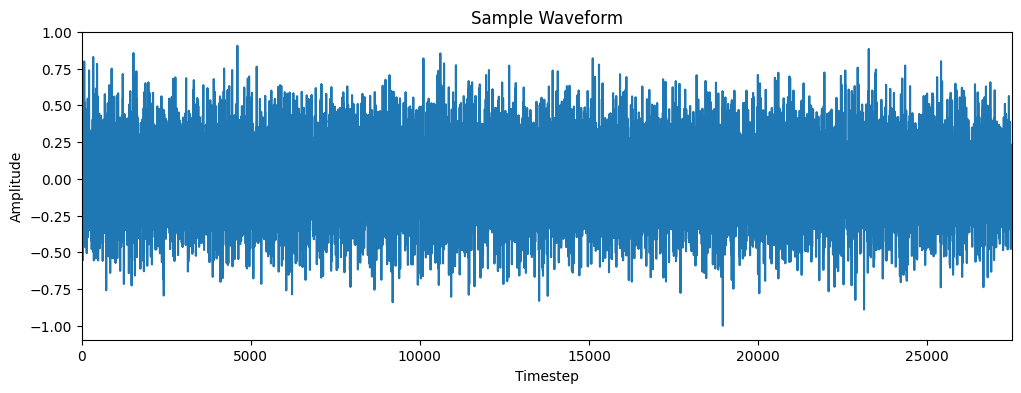

In [15]:
# Plot a sample waveform
plt.figure(figsize=(12, 4))
sample_waveform, _ = dataset[0]
plt.plot(sample_waveform.numpy())
plt.title("Sample Waveform")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.xlim(0,27500)
plt.show()

### Let's save the dataset to a single file for convenience

In [13]:
torch.save(dataset, 'PyTorch_Synthetic_Data/synthetic_event_dataset.pt')